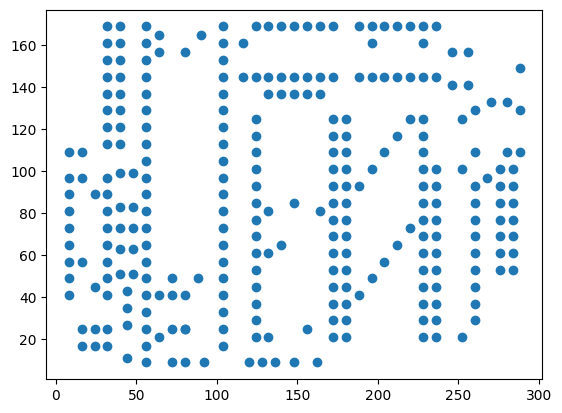

In [1]:
# Reading file

import numpy as np
import matplotlib.pyplot as plt

class City:
    id: int
    x: float
    y: float

    def __init__(self, id, x, y):
        self.x = float(x)
        self.y = float(y)
        self.id = int(id)

#file_name = "eil51.tsp.txt"
file_name = "a280.tsp.txt"
#file_name = "pcb442.tsp.txt"

intro_lines = 6        # MAKE THEM CONSTANT
cities_amount = 280     # MAKE THEM CONSTANT

cities = []
with open(file_name,"r") as f:
    for i in range(intro_lines):
        f.readline()
    for i in range(cities_amount):
        line = f.readline()
        id, x, y = line.split()
        cities.append(City(id, x, y))

coordinates_x = []
coordinates_y = []
for City in cities:
    coordinates_x.append(City.x)
    coordinates_y.append(City.y)
plt.scatter(coordinates_x, coordinates_y)

Init Path
True
34434.84526951124


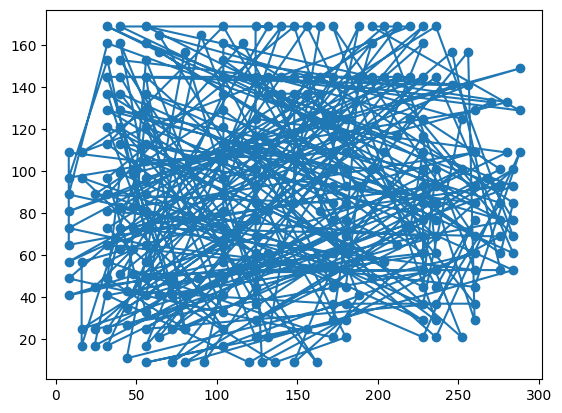

Gready Path
True
7011.467981428318


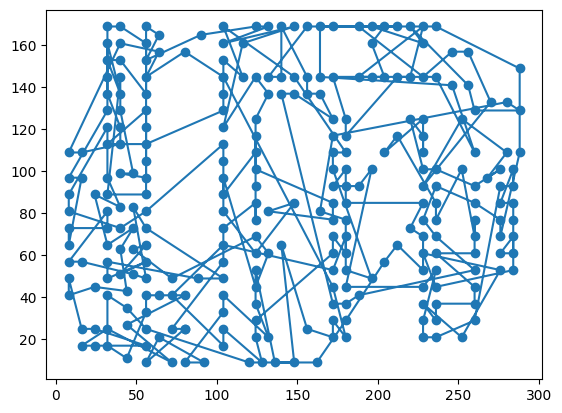

Simulated Annealing Solution
True
8863.562617833206


C:\Users\pmchrist\AppData\Local\Temp\ipykernel_14368\2661959285.py:169: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):   # Value is >1 if solution is better anyway, otherwise Metropolis is used


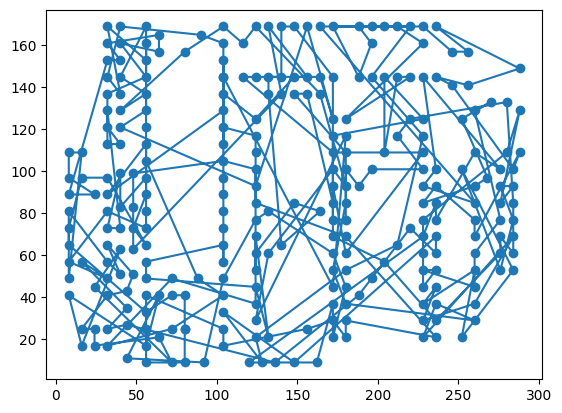

Worse Solutions accepted:  1416


In [2]:
import copy

class Path:
    city_ids = []

    def __init__(self, city_ids = []):
        self.city_ids = copy.deepcopy(city_ids)

    # Finds overall size of the path with Euclidean Distance (Fitness Function)
    def eval_distance(self):
        distance = 0
        for i in range(len(self.city_ids)-1):            
            # Because cities ids are starting from 1, and array starts at 0
            distance += np.sqrt(
            (cities[self.city_ids[i+1]-1].x - cities[self.city_ids[i]-1].x)**2 + 
            (cities[self.city_ids[i+1]-1].y - cities[self.city_ids[i]-1].y)**2 )
        return distance

    # Path is invalid if returned to non starting location at the end
    def eval_validity(self):
        if self.city_ids[0] == self.city_ids[-1]:
            return True
        else: return False

    # Visualize Path
    def visualize(self):
        coordinates_x = []
        coordinates_y = []
        for i in self.city_ids:
            coordinates_x.append(cities[i-1].x)       # Because cities ids are starting from 1, and array starts at 0
            coordinates_y.append(cities[i-1].y)
        plt.scatter(coordinates_x, coordinates_y)
        plt.plot(coordinates_x, coordinates_y)
        plt.show()
    # Print Path
    def visualize_print(self):
        print(self.city_ids)

    # Generating new paths
    # Random Permutations, k=amount of swaps
    def generate_new_path_random_swapping(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            city_ids_new[ids_to_swap[j]], city_ids_new[ids_to_swap[j+1]] = city_ids_new[ids_to_swap[j+1]], city_ids_new[ids_to_swap[j]]
        return Path(city_ids_new)
    # Inserting of vertices, k=amount of inserts
    # Take a vertex, place it in a location, shift other
    def generate_new_path_insertting(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k*2)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(0, k, 2):
            # Saving Value
            insert_value = city_ids_new[ids_to_swap[j+1]]
            # Shifting
            city_ids_new[ids_to_swap[j]+1:ids_to_swap[j+1]+1] = city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] 
            # Inserting
            city_ids_new[ids_to_swap[j]] = insert_value
        return Path(city_ids_new)
    # k-Opt
    def generate_new_path_k_opt(self, k):
        city_ids_new = copy.deepcopy(self.city_ids)

        ids_to_swap = np.random.randint(1, len(self.city_ids)-1, k)   # We are not swapping start and end
        ids_to_swap.sort()

        for j in range(k-1):
            city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]] = reversed(city_ids_new[ids_to_swap[j]:ids_to_swap[j+1]])
        return Path(city_ids_new)
                

# Generating an initial guess for the Path (Simplest way to create initial guess is just to shuffle)
import random
random.seed(42)
shuffled = sorted(cities, key=lambda k: random.random())
shuffled.append(shuffled[0])    # So that path is cycle
city_ids_init_path = []
for city in shuffled:
    city_ids_init_path.append(city.id)
initial_path = Path(city_ids_init_path)
print("Init Path")
print(initial_path.eval_validity())     # If everything is ok it should be True
print(initial_path.eval_distance())     # Evaluate circuit size
initial_path.visualize()                # And see it


# Iterative Method (Greedy) to find the solution
def greedy_solution(search_method, k, path, step_max, visualize_results):
    # Random Permutations to find the better path
    for i in range(step_max):
        if search_method == "random":
            new_path = path.generate_new_path_random_swapping(k) # k = Amount of swaps
        if search_method == "insert":
            new_path = path.generate_new_path_insertting(k)      # k = Amount of inserts
        if search_method == "k-opt":
            new_path = path.generate_new_path_k_opt(k)           # k = amount of rewires

        if new_path.eval_distance() < path.eval_distance():
            path = new_path
    print("Gready Path")
    print(path.eval_validity())     # If everything is ok it should be True
    print(path.eval_distance())     # Evaluate circuit size
    path.visualize()                # And see it
    return path

step_max = 10_000
greedy_solution("k-opt", 2, initial_path, step_max, True)


# Simulated Annealing
def annealing_solution(search_method, k, init_path, step_max, mc_chain, visualize_results):

    best_path = init_path
    current_path = init_path
    current_energy = init_path.eval_distance()

    step = 0
    inner_loop = mc_chain    # Monte Carlo chain size
    outer_loop =  step_max/inner_loop
    
    # Cooling Schedules

    temp_max = initial_path.eval_distance()/cities_amount   # Average path size in the beginning is a good guess, as it is close to the first possible optimization
    temp_min = 0
    temp_current = temp_max

    # http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/
    def cool_lin_a():
        return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)
    def cool_quad_a():
        return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)**2
    def cool_exp_a():
        return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)**np.sqrt(step)
    def cool_cos_a():
        return temp_min + 0.5*(temp_max - temp_min) * (1 + np.cos(step*np.pi/outer_loop))

    cooling_arr = []
    worse_sols = 0  # Keeping up with the chosen solutions that are worse than current one
    # Annealing Schedule
    while step < outer_loop:
        
        step += 1
        mc_step = 0
        #cooling_arr_temp = []

        while mc_step < inner_loop:

            mc_step += 1

            # Get candidate solution
            if search_method == "random":
                candidate_path = current_path.generate_new_path_random_swapping(k) # k = Amount of swaps
            if search_method == "insert":
                candidate_path = current_path.generate_new_path_insertting(k)      # k = Amount of inserts
            if search_method == "k-opt":
                candidate_path = current_path.generate_new_path_k_opt(k)           # k = amount of rewires

            candidate_energy = candidate_path.eval_distance()
            delta_energy = candidate_energy - current_energy    # Positive if solution is better, and is always accepted
            if delta_energy < 0:
                best_path = candidate_path

            if np.random.random() < np.exp(-delta_energy / temp_current):   # Value is >1 if solution is better anyway, otherwise Metropolis is used
                if delta_energy > 0:
                    worse_sols += 1
                current_energy = candidate_energy
                current_path = candidate_path
                cooling_arr.append(candidate_energy)
        
        # Cooling Function
        temp_current = cool_quad_a()
        #cooling_arr.append(cooling_arr_temp)


    # Generate some final stats
    if visualize_results:
        print("Simulated Annealing Solution")
        print(best_path.eval_validity())     # If everything is ok it should be True
        print(best_path.eval_distance())     # Evaluate circuit size
        best_path.visualize()                # And see it
        print("Worse Solutions accepted: ", worse_sols)
        
    return best_path, cooling_arr

mc_chain = 100
best_sol, all_sol = annealing_solution("k-opt", 2, initial_path, step_max, mc_chain, True)


In [3]:
# Checking influence of mc_chain length on the result
#
#bootstraps = 20
#
#step_max = 20_000
#
#for mc_chain in [1, 10, 100]:
#    results = []
#    for j in range(bootstraps):
#        best_path, found_paths = annealing_solution("k-opt", 2, initial_path, step_max, mc_chain, False)
#        results.append(best_path.eval_distance())
#    print("MC chain size ", mc_chain)
#    print("Average Value ", np.mean(results))
#    print("STD ", np.std(results))
#    print()

# Comparing MC chain size

In [4]:
# Checking influence of mc_chain length on the result

step_max = 100_000

best_path_2, found_paths_2 = annealing_solution("random", 2, initial_path, step_max, 5, False)
best_path_500, found_paths_500 = annealing_solution("random", 2, initial_path, step_max, 250, False)

C:\Users\pmchrist\AppData\Local\Temp\ipykernel_14368\2661959285.py:169: RuntimeWarning: overflow encountered in exp
  if np.random.random() < np.exp(-delta_energy / temp_current):   # Value is >1 if solution is better anyway, otherwise Metropolis is used


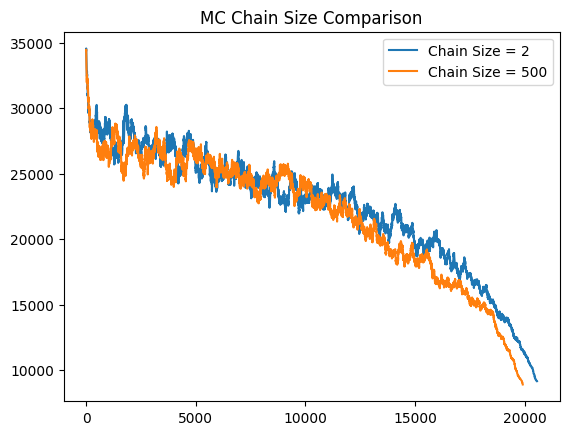

In [5]:
plt.title("MC Chain Size Comparison")

plt.plot(found_paths_2, label='Chain Size = 2')
plt.plot(found_paths_500, label='Chain Size = 500')

plt.legend()
plt.show()

# Cooling Functions

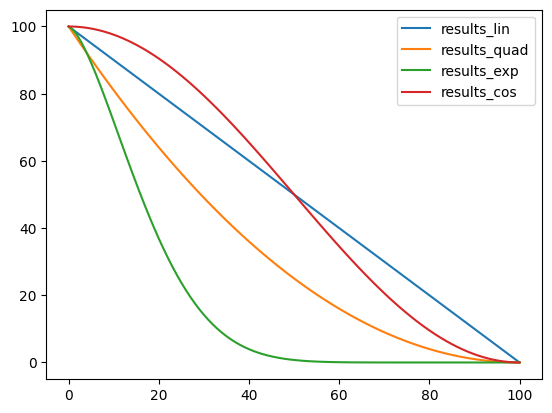

In [6]:
# no alpha, goes to temp_min gradually
# http://what-when-how.com/artificial-intelligence/a-comparison-of-cooling-schedules-for-simulated-annealing-artificial-intelligence/
def cool_lin_a():
    return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)
def cool_quad_a():
    return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)**2
def cool_exp_a():
    return temp_min + (temp_max - temp_min) * ((outer_loop - step)/outer_loop)**np.sqrt(step)
def cool_cos_a():
    return temp_min + 0.5*(temp_max - temp_min) * (1 + np.cos(step*np.pi/outer_loop))

temp_min = 0
temp_max = 100
temp = temp_max
outer_loop = 100

results_lin = []
results_quad = []
results_exp = []
results_cos = []

for step in range(outer_loop+1):
    results_lin.append(cool_lin_a())
    results_quad.append(cool_quad_a())
    results_exp.append(cool_exp_a())
    results_cos.append(cool_cos_a())


plt.plot(results_lin, label="results_lin")
plt.plot(results_quad, label="results_quad")
plt.plot(results_exp, label="results_exp")
plt.plot(results_cos, label="results_cos")
plt.legend()
plt.show()

# Future Discussions and further optimizations

PreCalculate Distance between all cities and use lookup table

There are so many parameters, it makes this method really complicated to use in real world. To combar this we implemented cooling function without alpha parameter. Yet, still a lot of parameters